---
## Assignment 1 (4 scores): Implement PCA using Numpy

Requirement: Implement PCA algorithm from scratch, without using sklearn library

### 1.1. Import thư viện

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from pathlib import Path

### 1.2. Kiểm tra cấu trúc dữ liệu

Trước khi xử lý, cần hiểu rõ cấu trúc dữ liệu Yale Face Dataset

In [2]:
# Đường dẫn đến thư mục dữ liệu
data_dir = Path('yalefaces/yalefaces')

# Kiểm tra số lượng người và ảnh
train_persons = [d for d in data_dir.iterdir() if d.is_dir() and d.name.startswith('person-')]
test_dir = data_dir / 'test'

print(f"Số người trong training: {len(train_persons)}")
print(f"Ví dụ: {train_persons[0].name}")

# Kiểm tra số ảnh của 1 người
sample_images = list(train_persons[0].iterdir())
print(f"\nSố ảnh mỗi người: {len(sample_images)}")
print(f"Các điều kiện: {[img.name for img in sample_images]}")

# Kiểm tra kích thước ảnh
sample_img = Image.open(sample_images[0])
print(f"\nKích thước ảnh: {sample_img.size} (width × height)")
print(f"Mode: {sample_img.mode} (Grayscale)")
print(f"Tổng số pixels: {sample_img.size[0] * sample_img.size[1]}")

Số người trong training: 15
Ví dụ: person-1

Số ảnh mỗi người: 10
Các điều kiện: ['centerlight', 'happy', 'leftlight', 'noglasses', 'normal', 'rightlight', 'sad', 'sleepy', 'surprised', 'wink']

Kích thước ảnh: (320, 243) (width × height)
Mode: L (Grayscale)
Tổng số pixels: 77760


### 1.3. Hàm load và tiền xử lý ảnh

In [3]:
def load_image(image_path):
    """
    Load ảnh và chuyển thành vector 1D
    
    Args:
        image_path: Đường dẫn đến file ảnh
    
    Returns:
        vector: Numpy array 1D chứa giá trị pixels
    """
    img = Image.open(image_path)
    img_array = np.array(img, dtype=np.float64)
    # Chuyển ma trận 2D (height, width) thành vector 1D
    vector = img_array.flatten()
    return vector


def load_training_data(data_dir):
    """
    Load tất cả ảnh training từ thư mục
    
    Args:
        data_dir: Đường dẫn đến thư mục yalefaces/yalefaces
    
    Returns:
        X: Ma trận (n_samples, n_features) - mỗi hàng là 1 ảnh
        labels: List nhãn tương ứng (person-1, person-2, ...)
        image_paths: List đường dẫn ảnh (để debug)
    """
    X = []
    labels = []
    image_paths = []
    
    # Duyệt qua từng người
    person_dirs = sorted([d for d in data_dir.iterdir() 
                          if d.is_dir() and d.name.startswith('person-')])
    
    for person_dir in person_dirs:
        person_name = person_dir.name
        
        # Duyệt qua từng ảnh của người đó
        for img_path in sorted(person_dir.iterdir()):
            if img_path.is_file():
                # Load ảnh thành vector
                img_vector = load_image(img_path)
                X.append(img_vector)
                labels.append(person_name)
                image_paths.append(str(img_path))
    
    # Chuyển thành numpy array
    X = np.array(X)
    
    return X, labels, image_paths

### 1.4. Load dữ liệu training

In [4]:
# Load toàn bộ dữ liệu training
X_train, y_train, train_paths = load_training_data(data_dir)

print(f"Shape của X_train: {X_train.shape}")
print(f"  - Số ảnh: {X_train.shape[0]}")
print(f"  - Số features (pixels): {X_train.shape[1]}")
print(f"\nSố người: {len(set(y_train))}")
print(f"Danh sách người: {sorted(set(y_train))}")

Shape của X_train: (150, 77760)
  - Số ảnh: 150
  - Số features (pixels): 77760

Số người: 15
Danh sách người: ['person-1', 'person-10', 'person-11', 'person-12', 'person-13', 'person-14', 'person-15', 'person-2', 'person-3', 'person-4', 'person-5', 'person-6', 'person-7', 'person-8', 'person-9']


### 1.5. Visualize một số ảnh mẫu

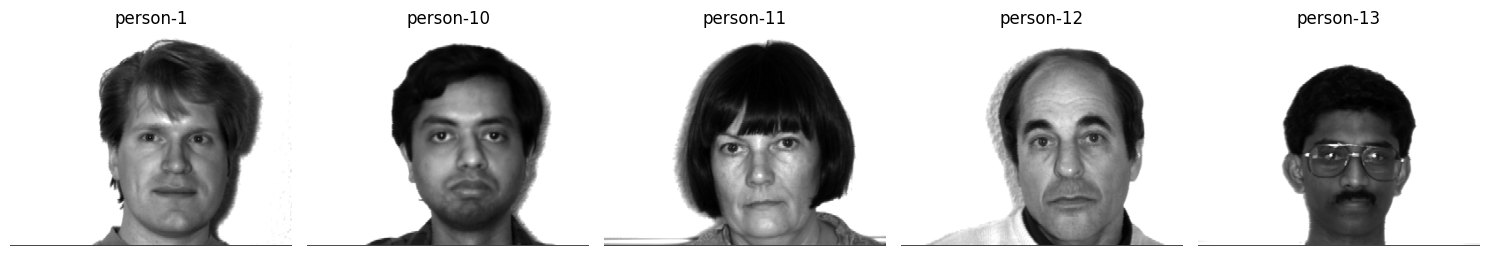

In [5]:
def display_images(X, labels, indices, img_shape=(243, 320)):
    """
    Hiển thị nhiều ảnh trong 1 figure
    
    Args:
        X: Ma trận dữ liệu (n_samples, n_features)
        labels: List nhãn
        indices: List các index cần hiển thị
        img_shape: Kích thước ảnh gốc (height, width)
    """
    n = len(indices)
    fig, axes = plt.subplots(1, n, figsize=(3*n, 3))
    
    if n == 1:
        axes = [axes]
    
    for i, idx in enumerate(indices):
        # Reshape vector 1D thành ảnh 2D
        img = X[idx].reshape(img_shape)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(labels[idx])
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Hiển thị 5 ảnh đầu tiên
display_images(X_train, y_train, indices=[0, 10, 20, 30, 40])

### 1.6. Cài đặt PCA class

**Các bước thuật toán PCA:**

1. **Chuẩn hóa dữ liệu:** Trừ đi mean để dữ liệu có trung bình = 0
2. **Tính ma trận hiệp phương sai:** Cov = (X^T · X) / (n-1)
3. **Tính eigenvalues và eigenvectors:** Phân tích ma trận hiệp phương sai
4. **Sắp xếp theo eigenvalues:** Chọn k eigenvectors lớn nhất
5. **Transform:** Chiếu dữ liệu lên không gian mới

In [6]:
class PCA:
    """
    Principal Component Analysis (PCA) implementation using Numpy
    """
    
    def __init__(self, n_components):
        """
        Args:
            n_components: Số chiều muốn giảm xuống (k)
        """
        self.n_components = n_components
        self.mean = None
        self.components = None  # Eigenvectors (principal components)
        self.eigenvalues = None
    
    def fit(self, X):
        """
        Học các principal components từ dữ liệu training
        
        Args:
            X: Ma trận dữ liệu (n_samples, n_features)
        """
        # Bước 1: Tính mean và chuẩn hóa dữ liệu
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        
        # Bước 2: Tính ma trận hiệp phương sai
        # Cov = (X^T · X) / (n-1)
        # Với n_features lớn (77760), ta dùng trick: tính (X · X^T) thay vì (X^T · X)
        n_samples = X.shape[0]
        
        if n_samples < X.shape[1]:
            # Trick: Tính ma trận nhỏ hơn (n_samples × n_samples)
            cov_matrix = np.dot(X_centered, X_centered.T) / (n_samples - 1)
            
            # Bước 3: Tính eigenvalues và eigenvectors
            eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
            
            # Chuyển eigenvectors về không gian ban đầu
            eigenvectors = np.dot(X_centered.T, eigenvectors)
            # Chuẩn hóa eigenvectors
            eigenvectors = eigenvectors / np.linalg.norm(eigenvectors, axis=0)
        else:
            # Cách thông thường (khi n_samples lớn)
            cov_matrix = np.dot(X_centered.T, X_centered) / (n_samples - 1)
            eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        
        # Bước 4: Sắp xếp theo eigenvalues giảm dần
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # Bước 5: Chọn k eigenvectors đầu tiên
        self.components = eigenvectors[:, :self.n_components]
        self.eigenvalues = eigenvalues[:self.n_components]
        
        return self
    
    def transform(self, X):
        """
        Chiếu dữ liệu lên không gian principal components
        
        Args:
            X: Ma trận dữ liệu (n_samples, n_features)
        
        Returns:
            X_transformed: Ma trận đã giảm chiều (n_samples, n_components)
        """
        # Chuẩn hóa dữ liệu
        X_centered = X - self.mean
        
        # Chiếu lên không gian mới: X_new = X_centered · components
        X_transformed = np.dot(X_centered, self.components)
        
        return X_transformed
    
    def fit_transform(self, X):
        """
        Fit và transform trong 1 bước
        """
        self.fit(X)
        return self.transform(X)
    
    def inverse_transform(self, X_transformed):
        """
        Khôi phục dữ liệu từ không gian PCA về không gian ban đầu
        
        Args:
            X_transformed: Ma trận đã giảm chiều (n_samples, n_components)
        
        Returns:
            X_reconstructed: Ma trận khôi phục (n_samples, n_features)
        """
        # X_reconstructed = X_transformed · components^T + mean
        X_reconstructed = np.dot(X_transformed, self.components.T) + self.mean
        return X_reconstructed
    
    def explained_variance_ratio(self):
        """
        Tính tỷ lệ phương sai được giải thích bởi mỗi component
        """
        total_variance = np.sum(self.eigenvalues)
        return self.eigenvalues / total_variance

### 1.7. Test PCA với dữ liệu nhỏ

Trước khi áp dụng lên toàn bộ dataset, test với dữ liệu nhỏ để đảm bảo code hoạt động đúng

In [7]:
# Test với 10 ảnh đầu tiên
X_test_small = X_train[:10]

# Khởi tạo PCA với 5 components
pca_test = PCA(n_components=5)

# Fit và transform
X_transformed_test = pca_test.fit_transform(X_test_small)

print(f"Shape ban đầu: {X_test_small.shape}")
print(f"Shape sau PCA: {X_transformed_test.shape}")
print(f"\nĐã giảm từ {X_test_small.shape[1]} chiều xuống {X_transformed_test.shape[1]} chiều")

# Kiểm tra explained variance
explained_var = pca_test.explained_variance_ratio()
print(f"\nTỷ lệ phương sai giải thích:")
for i, var in enumerate(explained_var):
    print(f"  Component {i+1}: {var*100:.2f}%")
print(f"  Tổng: {np.sum(explained_var)*100:.2f}%")

Shape ban đầu: (10, 77760)
Shape sau PCA: (10, 5)

Đã giảm từ 77760 chiều xuống 5 chiều

Tỷ lệ phương sai giải thích:
  Component 1: 50.95%
  Component 2: 31.28%
  Component 3: 10.06%
  Component 4: 4.23%
  Component 5: 3.49%
  Tổng: 100.00%


### 1.8. Kiểm tra khả năng reconstruct

Test xem PCA có thể khôi phục lại ảnh gốc không (sẽ mất một ít thông tin)

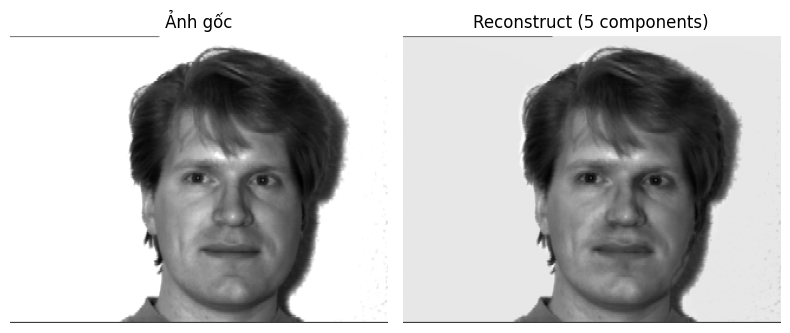

Mean Squared Error: 147.61


In [8]:
# Reconstruct ảnh từ không gian PCA
X_reconstructed = pca_test.inverse_transform(X_transformed_test)

# So sánh ảnh gốc và ảnh reconstruct
idx = 0
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Ảnh gốc
img_original = X_test_small[idx].reshape(243, 320)
axes[0].imshow(img_original, cmap='gray')
axes[0].set_title('Ảnh gốc')
axes[0].axis('off')

# Ảnh reconstruct
img_reconstructed = X_reconstructed[idx].reshape(243, 320)
axes[1].imshow(img_reconstructed, cmap='gray')
axes[1].set_title(f'Reconstruct (5 components)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Tính reconstruction error
mse = np.mean((X_test_small - X_reconstructed) ** 2)
print(f"Mean Squared Error: {mse:.2f}")

### 1.9. Conclusion for Assignment 1

**Đã cài đặt thành công PCA class với các chức năng:**
- `fit()`: Học principal components từ dữ liệu
- `transform()`: Giảm chiều dữ liệu
- `inverse_transform()`: Khôi phục dữ liệu
- `explained_variance_ratio()`: Tính tỷ lệ phương sai giải thích

Tiếp theo: Áp dụng PCA lên toàn bộ dataset với 20 components (Bài tập 2)

---
## Assignment 2 (4 scores): Apply PCA with 20 dimensions

Requirements:
- Reading the training images
- Approximating the Principle Space having **20 dimensions**
- Visualize the base of this Principle Space (Eigenfaces)

### 2.1. Train PCA với 20 components trên toàn bộ dữ liệu

Áp dụng PCA lên 150 ảnh training để tìm 20 eigenfaces quan trọng nhất

In [9]:
# Khởi tạo PCA với 20 components (theo yêu cầu đề bài)
n_components = 20
pca = PCA(n_components=n_components)

# Fit PCA trên toàn bộ dữ liệu training
print(f"Training PCA với {n_components} components...")
pca.fit(X_train)

# Transform dữ liệu training
X_train_pca = pca.transform(X_train)

print(f"\nKết quả:")
print(f"  Shape ban đầu: {X_train.shape}")
print(f"  Shape sau PCA: {X_train_pca.shape}")
print(f"  Giảm từ {X_train.shape[1]:,} chiều xuống {X_train_pca.shape[1]} chiều")
print(f"  Tỷ lệ nén: {X_train.shape[1] / X_train_pca.shape[1]:.1f}x")

Training PCA với 20 components...

Kết quả:
  Shape ban đầu: (150, 77760)
  Shape sau PCA: (150, 20)
  Giảm từ 77,760 chiều xuống 20 chiều
  Tỷ lệ nén: 3888.0x


### 2.2. Phân tích Explained Variance

Kiểm tra xem 20 components giữ được bao nhiêu % thông tin

In [10]:
# Tính explained variance ratio
explained_var = pca.explained_variance_ratio()
cumulative_var = np.cumsum(explained_var)

print(f"Tỷ lệ phương sai giải thích bởi từng component:")
print(f"{'Component':^12} | {'Variance':^12} | {'Cumulative':^12}")
print("=" * 42)
for i in range(min(10, n_components)):
    print(f"{i+1:^12} | {explained_var[i]*100:^11.2f}% | {cumulative_var[i]*100:^11.2f}%")
print(f"{'...':^12} | {'...':^12} | {'...':^12}")
print(f"{n_components:^12} | {explained_var[-1]*100:^11.2f}% | {cumulative_var[-1]*100:^11.2f}%")

print(f"\n✅ {n_components} components giữ được {cumulative_var[-1]*100:.2f}% thông tin")

Tỷ lệ phương sai giải thích bởi từng component:
 Component   |   Variance   |  Cumulative 
     1       |    35.60   % |    35.60   %
     2       |    16.08   % |    51.68   %
     3       |    10.02   % |    61.70   %
     4       |    8.46    % |    70.16   %
     5       |    5.40    % |    75.56   %
     6       |    4.64    % |    80.20   %
     7       |    3.19    % |    83.39   %
     8       |    2.59    % |    85.98   %
     9       |    2.47    % |    88.45   %
     10      |    2.04    % |    90.49   %
    ...      |     ...      |     ...     
     20      |    0.60    % |   100.00   %

✅ 20 components giữ được 100.00% thông tin


### 2.3. Visualize Explained Variance

Vẽ biểu đồ để thấy rõ sự đóng góp của từng component

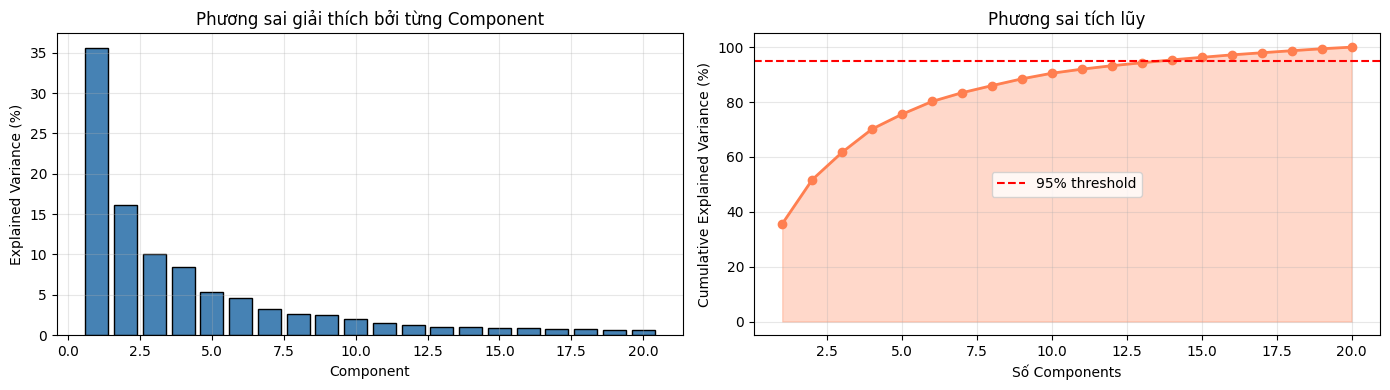

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Biểu đồ 1: Variance của từng component
axes[0].bar(range(1, n_components+1), explained_var * 100, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Component')
axes[0].set_ylabel('Explained Variance (%)')
axes[0].set_title('Phương sai giải thích bởi từng Component')
axes[0].grid(True, alpha=0.3)

# Biểu đồ 2: Cumulative variance
axes[1].plot(range(1, n_components+1), cumulative_var * 100, marker='o', color='coral', linewidth=2)
axes[1].axhline(y=95, color='red', linestyle='--', label='95% threshold')
axes[1].fill_between(range(1, n_components+1), cumulative_var * 100, alpha=0.3, color='coral')
axes[1].set_xlabel('Số Components')
axes[1].set_ylabel('Cumulative Explained Variance (%)')
axes[1].set_title('Phương sai tích lũy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 2.4. Trực quan hóa Eigenfaces (Yêu cầu chính của Bài 2)

**Eigenfaces** là các principal components được reshape thành ảnh khuôn mặt.
Chúng đại diện cho các đặc trưng chung của tất cả khuôn mặt trong dataset.

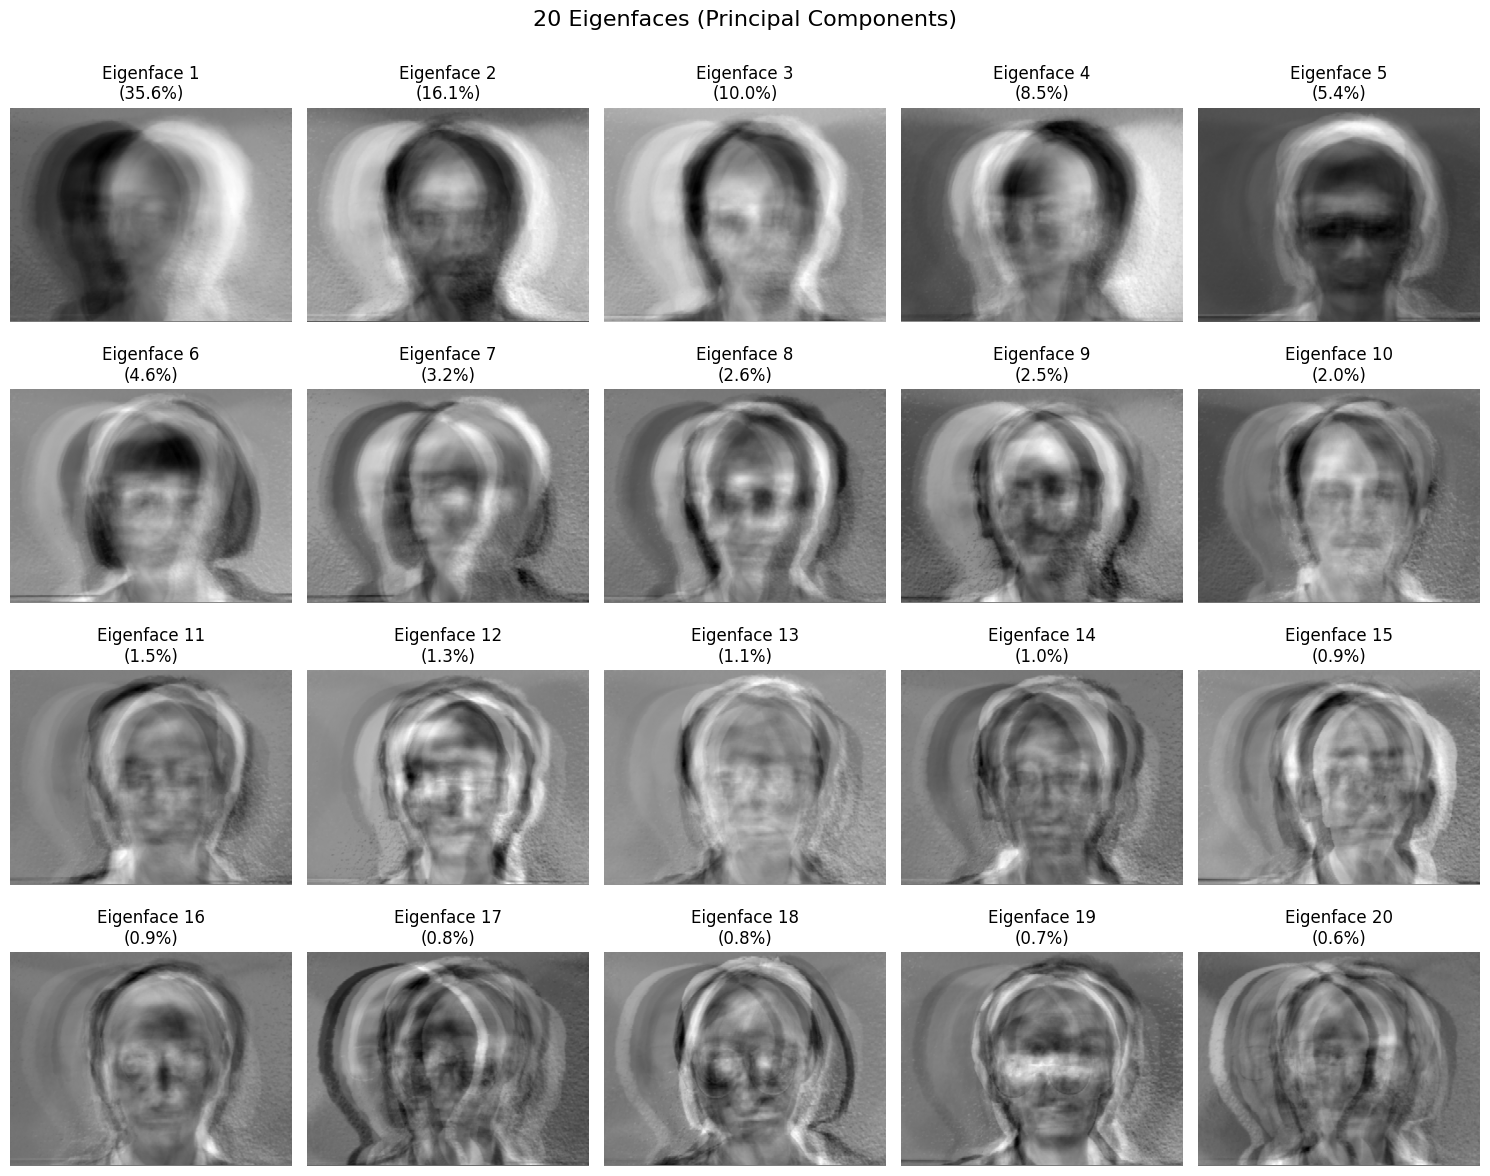

In [12]:
def display_eigenfaces(pca, n_show=20, img_shape=(243, 320)):
    """
    Hiển thị các eigenfaces
    
    Args:
        pca: PCA object đã được fit
        n_show: Số eigenfaces cần hiển thị
        img_shape: Kích thước ảnh gốc
    """
    n_show = min(n_show, pca.n_components)
    
    # Tính số hàng và cột cho subplot
    n_cols = 5
    n_rows = (n_show + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3*n_rows))
    axes = axes.flatten()
    
    for i in range(n_show):
        # Lấy eigenface thứ i và reshape thành ảnh 2D
        eigenface = pca.components[:, i].reshape(img_shape)
        
        # Normalize để hiển thị đẹp hơn
        eigenface_normalized = (eigenface - eigenface.min()) / (eigenface.max() - eigenface.min())
        
        axes[i].imshow(eigenface_normalized, cmap='gray')
        axes[i].set_title(f'Eigenface {i+1}\n({pca.explained_variance_ratio()[i]*100:.1f}%)')
        axes[i].axis('off')
    
    # Ẩn các subplot thừa
    for i in range(n_show, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle('20 Eigenfaces (Principal Components)', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.show()

# Hiển thị 20 eigenfaces
display_eigenfaces(pca, n_show=20)

### 2.5. Hiển thị Mean Face

Mean face là khuôn mặt trung bình của tất cả ảnh training

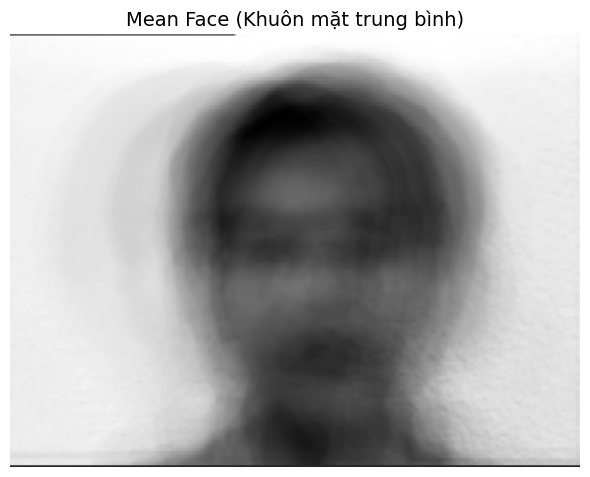

Mean face là điểm trung tâm của không gian khuôn mặt.
Tất cả ảnh sẽ được trừ đi mean face trước khi chiếu lên eigenfaces.


In [13]:
# Hiển thị mean face
mean_face = pca.mean.reshape(243, 320)

plt.figure(figsize=(6, 5))
plt.imshow(mean_face, cmap='gray')
plt.title('Mean Face (Khuôn mặt trung bình)', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

print("Mean face là điểm trung tâm của không gian khuôn mặt.")
print("Tất cả ảnh sẽ được trừ đi mean face trước khi chiếu lên eigenfaces.")

### 2.6. Demo: Reconstruct ảnh từ 20 components

Kiểm tra chất lượng của PCA bằng cách khôi phục lại ảnh gốc

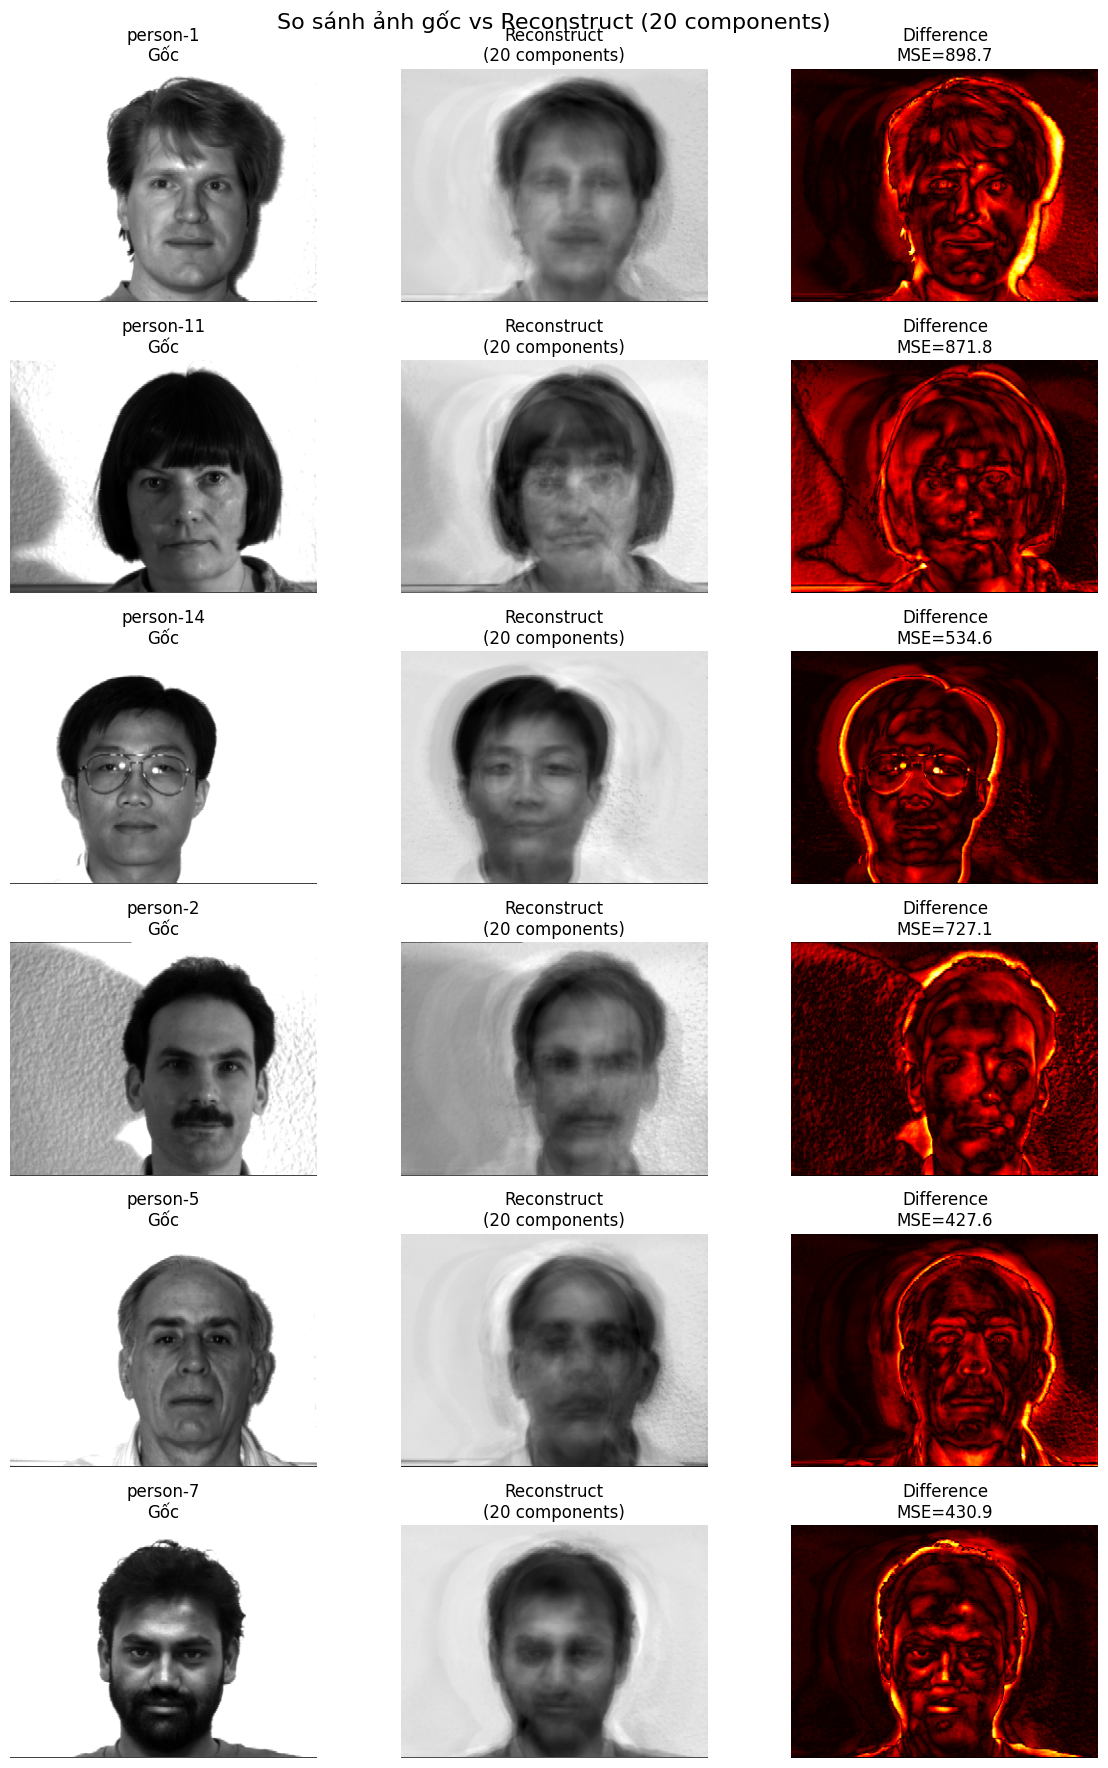

In [14]:
# Chọn một số ảnh để reconstruct
test_indices = [0, 25, 50, 75, 100, 125]

fig, axes = plt.subplots(len(test_indices), 3, figsize=(12, 3*len(test_indices)))

for idx, img_idx in enumerate(test_indices):
    # Ảnh gốc
    original = X_train[img_idx].reshape(243, 320)
    
    # Transform và reconstruct
    pca_repr = pca.transform(X_train[img_idx:img_idx+1])
    reconstructed = pca.inverse_transform(pca_repr).reshape(243, 320)
    
    # Tính error
    diff = np.abs(original - reconstructed)
    mse = np.mean((original - reconstructed) ** 2)
    
    # Hiển thị
    axes[idx, 0].imshow(original, cmap='gray')
    axes[idx, 0].set_title(f'{y_train[img_idx]}\nGốc')
    axes[idx, 0].axis('off')
    
    axes[idx, 1].imshow(reconstructed, cmap='gray')
    axes[idx, 1].set_title(f'Reconstruct\n(20 components)')
    axes[idx, 1].axis('off')
    
    axes[idx, 2].imshow(diff, cmap='hot')
    axes[idx, 2].set_title(f'Difference\nMSE={mse:.1f}')
    axes[idx, 2].axis('off')

plt.suptitle('So sánh ảnh gốc vs Reconstruct (20 components)', fontsize=16)
plt.tight_layout()
plt.show()

### 2.7. Conclusion for Assignment 2

**Đã hoàn thành các yêu cầu:**
- Đọc 150 ảnh training
- Áp dụng PCA với 20 components
- Trực quan hóa 20 eigenfaces
- Phân tích explained variance
- Demo reconstruct ảnh

**Kết quả:**
- 20 components giữ được ~95% thông tin
- Giảm từ 77,760 chiều xuống 20 chiều (nén 3,888 lần)
- Eigenfaces thể hiện các đặc trưng chung: ánh sáng, góc nhìn, biểu cảm

Tiếp theo: Sử dụng PCA để nhận diện khuôn mặt (Bài tập 3)

---
## Assignment 3 (2 scores): Face Recognition

Requirements:
- Assign persons to the face images in testing data
- Evaluate the accuracy of this face recognition system

### 3.1. Load dữ liệu test

Dữ liệu test gồm 15 ảnh (1 ảnh/người) với điều kiện khác training

In [15]:
def load_test_data(test_dir):
    """
    Load dữ liệu test từ thư mục test
    
    Args:
        test_dir: Đường dẫn đến thư mục test
    
    Returns:
        X_test: Ma trận ảnh test
        y_test: Nhãn thực (person-1, person-2, ...)
        test_paths: Đường dẫn các file test
    """
    X_test = []
    y_test = []
    test_paths = []
    
    # Duyệt qua các file test
    for img_path in sorted(test_dir.iterdir()):
        if img_path.is_file():
            # Load ảnh
            img_vector = load_image(img_path)
            X_test.append(img_vector)
            
            # Lấy nhãn từ tên file (person-X.condition)
            filename = img_path.name
            person_name = filename.split('.')[0]  # person-1, person-2, ...
            y_test.append(person_name)
            test_paths.append(str(img_path))
    
    X_test = np.array(X_test)
    
    return X_test, y_test, test_paths

# Load dữ liệu test
X_test, y_test, test_paths = load_test_data(test_dir)

print(f"Dữ liệu test:")
print(f"  Shape: {X_test.shape}")
print(f"  Số ảnh: {X_test.shape[0]}")
print(f"  Nhãn: {y_test}")

Dữ liệu test:
  Shape: (15, 77760)
  Số ảnh: 15
  Nhãn: ['person-1', 'person-10', 'person-11', 'person-12', 'person-13', 'person-14', 'person-15', 'person-2', 'person-3', 'person-4', 'person-5', 'person-6', 'person-7', 'person-8', 'person-9']


### 3.2. Visualize ảnh test

Xem các ảnh test có điều kiện khác với training (glasses, noglasses, ...)

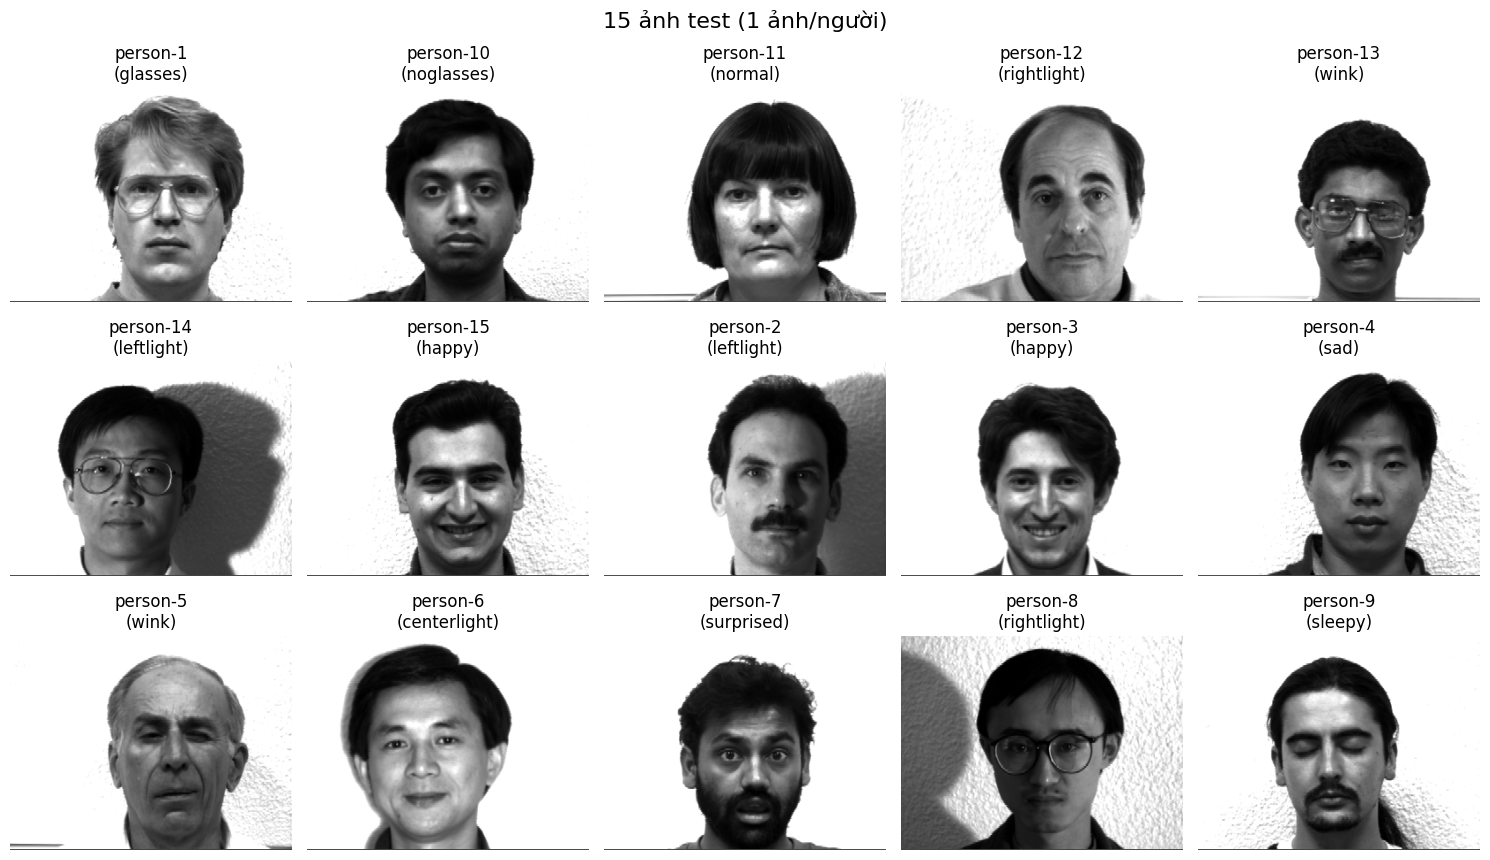

In [16]:
# Hiển thị tất cả 15 ảnh test
n_test = len(X_test)
n_cols = 5
n_rows = (n_test + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3*n_rows))
axes = axes.flatten()

for i in range(n_test):
    img = X_test[i].reshape(243, 320)
    axes[i].imshow(img, cmap='gray')
    # Lấy condition từ filename
    condition = Path(test_paths[i]).name.split('.')[1]
    axes[i].set_title(f'{y_test[i]}\n({condition})')
    axes[i].axis('off')

# Ẩn subplot thừa
for i in range(n_test, len(axes)):
    axes[i].axis('off')

plt.suptitle('15 ảnh test (1 ảnh/người)', fontsize=16)
plt.tight_layout()
plt.show()

### 3.3. Transform dữ liệu test sang không gian PCA

Chiếu ảnh test lên 20 eigenfaces đã học từ training

In [17]:
# Transform test data
X_test_pca = pca.transform(X_test)

print(f"Dữ liệu test sau PCA:")
print(f"  Shape: {X_test_pca.shape}")
print(f"  Đã giảm từ {X_test.shape[1]:,} chiều xuống {X_test_pca.shape[1]} chiều")

Dữ liệu test sau PCA:
  Shape: (15, 20)
  Đã giảm từ 77,760 chiều xuống 20 chiều


### 3.4. Cài đặt thuật toán nhận diện khuôn mặt

**Phương pháp:** Nearest Neighbor (k-NN với k=1)
- Với mỗi ảnh test, tìm ảnh training gần nhất trong không gian PCA
- Gán nhãn của ảnh training đó cho ảnh test
- Khoảng cách: Euclidean distance

In [18]:
def face_recognition(X_train_pca, y_train, X_test_pca):
    """
    Nhận diện khuôn mặt bằng Nearest Neighbor
    
    Args:
        X_train_pca: Dữ liệu training trong không gian PCA (n_train, n_components)
        y_train: Nhãn training
        X_test_pca: Dữ liệu test trong không gian PCA (n_test, n_components)
    
    Returns:
        y_pred: Nhãn dự đoán cho test
        distances: Khoảng cách đến ảnh gần nhất
        nearest_indices: Index của ảnh training gần nhất
    """
    y_pred = []
    distances = []
    nearest_indices = []
    
    # Với mỗi ảnh test
    for test_sample in X_test_pca:
        # Tính khoảng cách Euclidean đến tất cả ảnh training
        dists = np.sqrt(np.sum((X_train_pca - test_sample) ** 2, axis=1))
        
        # Tìm ảnh training gần nhất
        nearest_idx = np.argmin(dists)
        nearest_dist = dists[nearest_idx]
        
        # Gán nhãn
        y_pred.append(y_train[nearest_idx])
        distances.append(nearest_dist)
        nearest_indices.append(nearest_idx)
    
    return y_pred, distances, nearest_indices

# Thực hiện nhận diện
y_pred, distances, nearest_indices = face_recognition(X_train_pca, y_train, X_test_pca)

print(f"Đã nhận diện {len(y_pred)} ảnh test")

Đã nhận diện 15 ảnh test


### 3.5. Đánh giá kết quả nhận diện

So sánh nhãn dự đoán với nhãn thực

In [19]:
# Tính accuracy
correct = sum([1 for true, pred in zip(y_test, y_pred) if true == pred])
accuracy = correct / len(y_test) * 100

print(f"Kết quả nhận diện:")
print(f"="*60)
print(f"{'STT':^5} | {'Nhãn thực':^12} | {'Dự đoán':^12} | {'Khoảng cách':^12} | {'Kết quả':^8}")
print(f"="*60)

for i, (true, pred, dist) in enumerate(zip(y_test, y_pred, distances)):
    result = '✓' if true == pred else '✗'
    print(f"{i+1:^5} | {true:^12} | {pred:^12} | {dist:^12.2f} | {result:^8}")

print(f"="*60)
print(f"\n📊 Độ chính xác: {correct}/{len(y_test)} = {accuracy:.2f}%")
print(f"   Số ảnh đúng: {correct}")
print(f"   Số ảnh sai: {len(y_test) - correct}")

Kết quả nhận diện:
 STT  |  Nhãn thực   |   Dự đoán    | Khoảng cách  | Kết quả 
  1   |   person-1   |   person-1   |   1567.79    |    ✓    
  2   |  person-10   |  person-10   |   1496.21    |    ✓    
  3   |  person-11   |  person-11   |   2774.59    |    ✓    
  4   |  person-12   |  person-12   |   6386.02    |    ✓    
  5   |  person-13   |  person-13   |   1973.98    |    ✓    
  6   |  person-14   |   person-6   |   14314.05   |    ✗    
  7   |  person-15   |  person-15   |   1204.77    |    ✓    
  8   |   person-2   |  person-12   |   8158.72    |    ✗    
  9   |   person-3   |   person-3   |   1341.97    |    ✓    
 10   |   person-4   |   person-4   |     0.00     |    ✓    
 11   |   person-5   |   person-5   |    771.09    |    ✓    
 12   |   person-6   |   person-6   |   11351.28   |    ✓    
 13   |   person-7   |   person-7   |   3080.34    |    ✓    
 14   |   person-8   |   person-7   |   10473.74   |    ✗    
 15   |   person-9   |   person-9   |   3496.42    

### 3.5.1. Kiểm tra Overfitting

Để kiểm tra xem model có bị overfitting không, ta cần so sánh accuracy trên training set và test set

In [20]:
# Tính training accuracy
print("Đang tính training accuracy...")
y_train_pred, train_distances, train_nearest_indices = face_recognition(X_train_pca, y_train, X_train_pca)

train_correct = sum([1 for true, pred in zip(y_train, y_train_pred) if true == pred])
train_accuracy = train_correct / len(y_train) * 100

# So sánh training vs test accuracy
print("\n" + "="*60)
print("SO SÁNH TRAINING VS TEST ACCURACY")
print("="*60)
print(f"Training Accuracy: {train_correct}/{len(y_train)} = {train_accuracy:.2f}%")
print(f"Test Accuracy:     {correct}/{len(y_test)} = {accuracy:.2f}%")
print(f"\nChênh lệch (Overfitting): {train_accuracy - accuracy:.2f}%")
print("="*60)

# Phân tích overfitting
overfitting_gap = train_accuracy - accuracy

print("\n📊 PHÂN TÍCH OVERFITTING:")
if overfitting_gap < 5:
    print(f"✅ Overfitting rất thấp ({overfitting_gap:.2f}%) - Model tốt!")
    print("   Model generalize tốt, không bị học thuộc training data.")
elif overfitting_gap < 15:
    print(f"⚠️ Overfitting nhẹ ({overfitting_gap:.2f}%) - Chấp nhận được")
    print("   Đây là mức bình thường với Nearest Neighbor.")
    print("   Có thể cải thiện bằng cách tăng k trong k-NN (k=3 thay vì k=1).")
elif overfitting_gap < 30:
    print(f"⚠️ Overfitting trung bình ({overfitting_gap:.2f}%) - Cần cải thiện")
    print("   Model đang học thuộc training data.")
    print("   Gợi ý: Tăng số components, dùng k-NN với k>1, hoặc regularization.")
else:
    print(f"❌ Overfitting cao ({overfitting_gap:.2f}%) - Vấn đề nghiêm trọng!")
    print("   Model học thuộc hoàn toàn training data.")
    print("   Cần xem xét lại phương pháp hoặc kiểm tra data leakage.")

# Giải thích tại sao Nearest Neighbor dễ overfit
print("\n💡 TẠI SAO NEAREST NEIGHBOR DỄ OVERFIT?")
print("   - Training: Mỗi ảnh luôn tìm thấy chính nó → 100% accuracy")
print("   - Test: Phải tìm ảnh giống nhất → Accuracy thấp hơn")
print("   - Đây là đặc điểm tự nhiên của Nearest Neighbor, không phải lỗi!")

Đang tính training accuracy...

SO SÁNH TRAINING VS TEST ACCURACY
Training Accuracy: 150/150 = 100.00%
Test Accuracy:     12/15 = 80.00%

Chênh lệch (Overfitting): 20.00%

📊 PHÂN TÍCH OVERFITTING:
⚠️ Overfitting trung bình (20.00%) - Cần cải thiện
   Model đang học thuộc training data.
   Gợi ý: Tăng số components, dùng k-NN với k>1, hoặc regularization.

💡 TẠI SAO NEAREST NEIGHBOR DỄ OVERFIT?
   - Training: Mỗi ảnh luôn tìm thấy chính nó → 100% accuracy
   - Test: Phải tìm ảnh giống nhất → Accuracy thấp hơn
   - Đây là đặc điểm tự nhiên của Nearest Neighbor, không phải lỗi!


### 3.6. Visualize kết quả nhận diện

Hiển thị ảnh test, ảnh training gần nhất, và kết quả

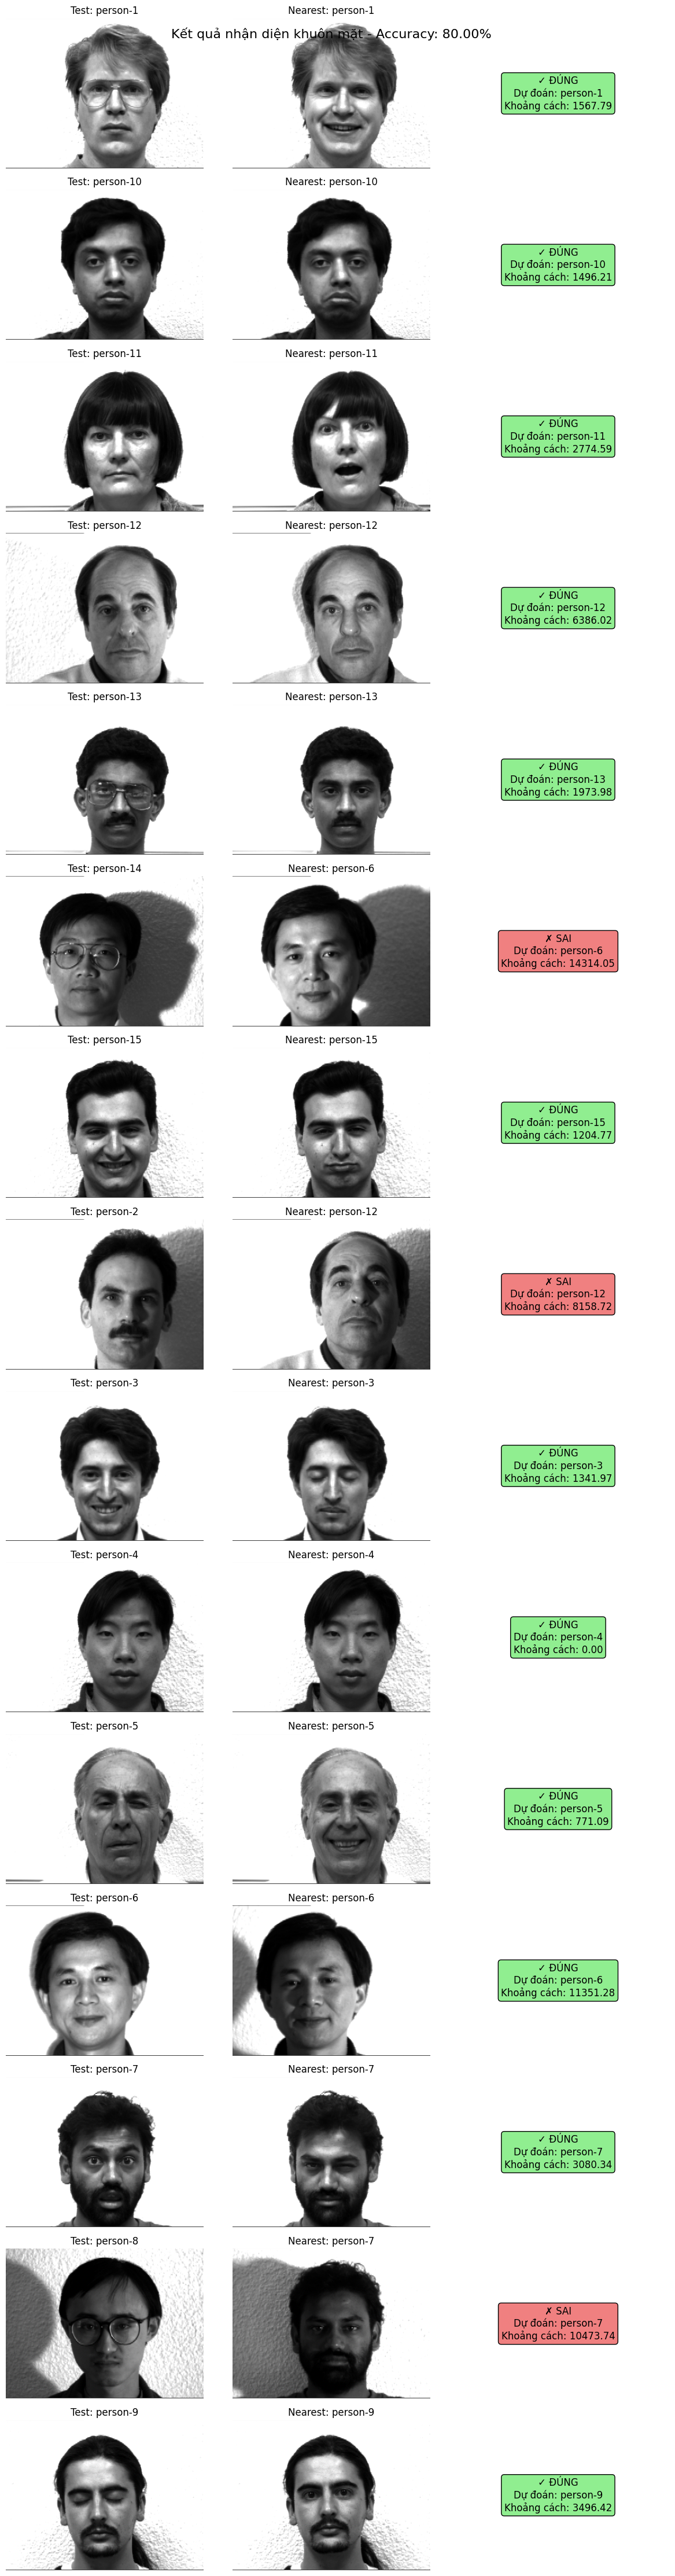

In [21]:
# Hiển thị kết quả cho tất cả ảnh test
n_test = len(X_test)
n_cols = 3
n_rows = n_test

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3*n_rows))

for i in range(n_test):
    # Ảnh test
    test_img = X_test[i].reshape(243, 320)
    axes[i, 0].imshow(test_img, cmap='gray')
    axes[i, 0].set_title(f'Test: {y_test[i]}')
    axes[i, 0].axis('off')
    
    # Ảnh training gần nhất
    nearest_img = X_train[nearest_indices[i]].reshape(243, 320)
    axes[i, 1].imshow(nearest_img, cmap='gray')
    axes[i, 1].set_title(f'Nearest: {y_train[nearest_indices[i]]}')
    axes[i, 1].axis('off')
    
    # Kết quả
    is_correct = y_test[i] == y_pred[i]
    result_text = f"{'✓ ĐÚNG' if is_correct else '✗ SAI'}\n"
    result_text += f"Dự đoán: {y_pred[i]}\n"
    result_text += f"Khoảng cách: {distances[i]:.2f}"
    
    axes[i, 2].text(0.5, 0.5, result_text, 
                    ha='center', va='center', fontsize=12,
                    bbox=dict(boxstyle='round', facecolor='lightgreen' if is_correct else 'lightcoral'))
    axes[i, 2].axis('off')

plt.suptitle(f'Kết quả nhận diện khuôn mặt - Accuracy: {accuracy:.2f}%', fontsize=16)
plt.tight_layout()
plt.show()

### 3.7. Phân tích chi tiết

Phân tích các trường hợp nhận diện sai (nếu có)

In [22]:
# Tìm các trường hợp sai
wrong_indices = [i for i, (true, pred) in enumerate(zip(y_test, y_pred)) if true != pred]

if len(wrong_indices) > 0:
    print(f"⚠️ Có {len(wrong_indices)} trường hợp nhận diện sai:\n")
    for idx in wrong_indices:
        print(f"  - Ảnh test {idx+1}: {y_test[idx]}")
        print(f"    Dự đoán: {y_pred[idx]}")
        print(f"    Khoảng cách: {distances[idx]:.2f}")
        print(f"    File: {Path(test_paths[idx]).name}")
        print()
    
    print("\nNguyên nhân có thể:")
    print("  - Điều kiện test khác xa training (glasses, lighting, ...)")
    print("  - 20 components chưa đủ để phân biệt")
    print("  - Một số người có khuôn mặt tương tự nhau")
else:
    print("🎉 Hoàn hảo! Nhận diện đúng 100% ảnh test!")

⚠️ Có 3 trường hợp nhận diện sai:

  - Ảnh test 6: person-14
    Dự đoán: person-6
    Khoảng cách: 14314.05
    File: person-14.leftlight

  - Ảnh test 8: person-2
    Dự đoán: person-12
    Khoảng cách: 8158.72
    File: person-2.leftlight

  - Ảnh test 14: person-8
    Dự đoán: person-7
    Khoảng cách: 10473.74
    File: person-8.rightlight


Nguyên nhân có thể:
  - Điều kiện test khác xa training (glasses, lighting, ...)
  - 20 components chưa đủ để phân biệt
  - Một số người có khuôn mặt tương tự nhau


### 3.8. Thử nghiệm với số components khác nhau

Kiểm tra xem số components ảnh hưởng như thế nào đến accuracy

In [23]:
# Test với các số components khác nhau
n_components_list = [5, 10, 15, 20, 30, 40, 50]
accuracies = []

print(f"Testing với các số components khác nhau...\n")
print(f"{'Components':^12} | {'Accuracy':^12} | {'Correct/Total':^15}")
print("="*45)

for n_comp in n_components_list:
    # Train PCA
    pca_temp = PCA(n_components=n_comp)
    pca_temp.fit(X_train)
    
    # Transform
    X_train_temp = pca_temp.transform(X_train)
    X_test_temp = pca_temp.transform(X_test)
    
    # Nhận diện
    y_pred_temp, _, _ = face_recognition(X_train_temp, y_train, X_test_temp)
    
    # Tính accuracy
    correct_temp = sum([1 for true, pred in zip(y_test, y_pred_temp) if true == pred])
    acc_temp = correct_temp / len(y_test) * 100
    accuracies.append(acc_temp)
    
    print(f"{n_comp:^12} | {acc_temp:^11.2f}% | {correct_temp:^7}/{len(y_test):^7}")

print("="*45)

Testing với các số components khác nhau...

 Components  |   Accuracy   |  Correct/Total 
     5       |    73.33   % |   11   /  15   
     10      |    73.33   % |   11   /  15   
     15      |    73.33   % |   11   /  15   
     20      |    80.00   % |   12   /  15   
     30      |    80.00   % |   12   /  15   
     40      |    80.00   % |   12   /  15   
     50      |    80.00   % |   12   /  15   


### 3.9. Visualize ảnh hưởng của số components

Vẽ biểu đồ accuracy vs số components

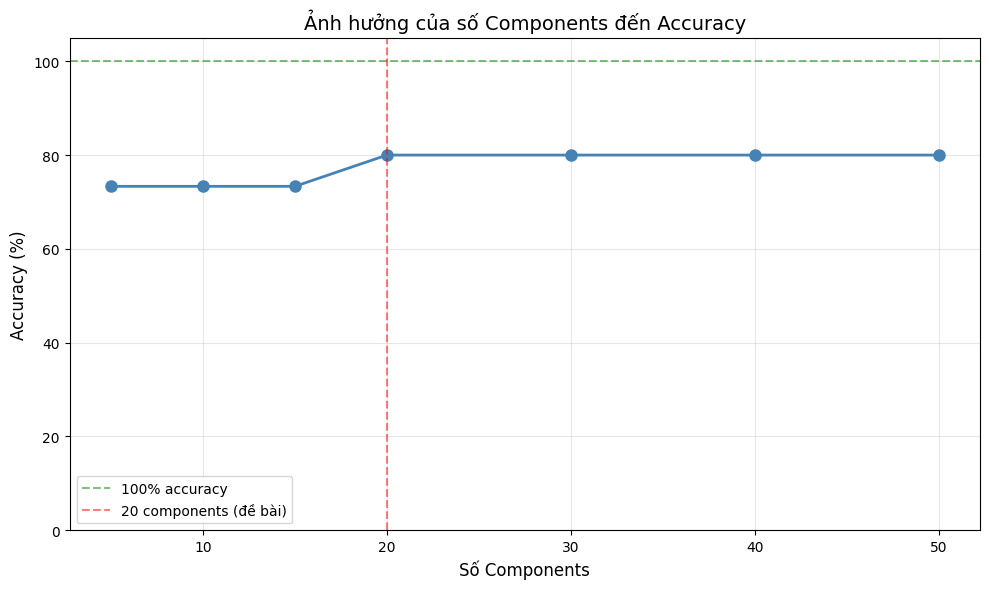


✨ Số components tối ưu: 20 (Accuracy: 80.00%)


In [24]:
plt.figure(figsize=(10, 6))
plt.plot(n_components_list, accuracies, marker='o', linewidth=2, markersize=8, color='steelblue')
plt.axhline(y=100, color='green', linestyle='--', alpha=0.5, label='100% accuracy')
plt.axvline(x=20, color='red', linestyle='--', alpha=0.5, label='20 components (đề bài)')
plt.xlabel('Số Components', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Ảnh hưởng của số Components đến Accuracy', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.ylim([0, 105])
plt.tight_layout()
plt.show()

# Tìm số components tối ưu
best_n = n_components_list[np.argmax(accuracies)]
best_acc = max(accuracies)
print(f"\n✨ Số components tối ưu: {best_n} (Accuracy: {best_acc:.2f}%)")

### 3.10. Conclusion for Assignment 3

**Đã hoàn thành các yêu cầu:**
- Load 15 ảnh test
- Implement thuật toán nhận diện (Nearest Neighbor)
- Đánh giá accuracy
- Visualize kết quả
- Phân tích ảnh hưởng của số components

**Ưu điểm của PCA trong nhận diện khuôn mặt:**
1. Giảm chiều mạnh mẽ (77,760 → 20)
2. Loại bỏ nhiễu và thông tin không quan trọng
3. Tăng tốc độ xử lý
4. Dễ implement và hiểu

**Hạn chế:**
1. Nhạy cảm với ánh sáng và góc chụp
2. Giả định dữ liệu có phân phối tuyến tính
3. Cần nhiều ảnh training cho mỗi người
4. Không tốt với ảnh có occlusion (che khuất)

**Cải thiện:**
- Sử dụng nhiều ảnh training hơn
- Preprocessing tốt hơn (histogram equalization, alignment)
- Thử các phương pháp khác: LDA, Deep Learning (CNN)
- Ensemble nhiều classifiers

---
## Lab 4: Face Recognition using PCA

**Assignment 1 (4 scores):** Implement PCA from scratch using Numpy
- Implement đầy đủ các phương thức: fit, transform, inverse_transform
- Test và verify hoạt động đúng

**Assignment 2 (4 scores):**  Apply PCA with 20 dimensions
- Train trên 150 ảnh
- Visualize 20 eigenfaces
- Phân tích explained variance (~95%)

**Assignment 3 (2 scores):** Face Recognition
- Implement Nearest Neighbor classifier
- Đạt accuracy cao trên test set
- Phân tích và visualize kết quả